# Laboratory Work 3

Text generation with RNN

# Environment Preparation

In [ ]:
!pip install datasets -q
!pip install langdetect -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# @title Imports {display-mode: "form"}

from google.colab import drive
import pandas as pd
from IPython.display import clear_output
import re
from gensim.models import Word2Vec
from datasets import load_dataset
from tqdm import tqdm
import numpy as np
import keras.backend as K
from keras.layers import Input, Dense, SimpleRNN, GRU, Layer, Embedding, Dropout, LSTM, Bidirectional
from keras import Model
import random
from langdetect import detect, DetectorFactory
from keras.models import Sequential
from keras.regularizers import l2
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# @title G-Drive {display-mode: "form"}

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title Env Preparation {display-mode: "form"}

pd.options.mode.chained_assignment = None
tqdm.pandas()
DetectorFactory.seed = 42

# Part 1. News

> *We've been burrying the pages*

> *We've been trying to erase this...*

На самом деле, я весьма долго искал подходящий датасет. С удовольствием бы обучил модель на текстах песен любимых исполнителей, но в большинстве датасетов с текстами песен их не было, а датасет с текстами с Гениуса оказался слишком тяжёлым. Большинство остальных датасетов же либо весьма специфичные, либо просто скучные. В итоге я решил остановиться на датасете с текстами новостей.

## Load Dataset

In [ ]:
df_news = load_dataset('GonzaloA/fake_news', split='train').to_pandas()
df_news

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


Generating train split:   0%|          | 0/24353 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/8117 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8117 [00:00<?, ? examples/s]

,Unnamed: 0,title,text,label
0,0,‘Maury’ Show Official Facebook Posts F*CKED U...,Maury is perhaps one of the trashiest shows on...,0
1,1,Trump’s Favorite News Channel Tries To Soothe...,"Yesterday, after the father of one of the UCLA...",0
2,2,"Russia warns Iraq, Kurds not to destabilize Mi...",MOSCOW (Reuters) - Russia on Wednesday warned ...,1
3,3,WATCH STEVE SCALISE Throw A Strike At The Nati...,"House Majority Whip Steve Scalise (R., La.) th...",0
4,4,Trump Will HATE What Stephen Colbert Just Did...,It can be said that Late Show host Stephen Col...,0
...,...,...,...,...
24348,24348,EU Parliament chief asks Poland to ensure MEPs...,WARSAW (Reuters) - The president of the Europe...,1
24349,24349,Chemical weapons watchdog found sarin used in ...,AMSTERDAM/UNITED NATIONS (Reuters) - An inquir...,1
24350,24350,"Melissa Harris-Perry Is DONE With MSNBC, Pens...","As you may or may not know at this point, MSNB...",0
24351,24351,Trump's pick for Navy secretary withdraws,WASHINGTON (Reuters) - U.S. President Donald T...,1


Я решил оставить для обучения тексты фейковых новостей

In [ ]:
df_news = df_news.loc[df_news['label'] == 1]
df_news

,Unnamed: 0,title,text,label
2,2,"Russia warns Iraq, Kurds not to destabilize Mi...",MOSCOW (Reuters) - Russia on Wednesday warned ...,1
6,6,EU's Verhofstadt pokes fun at British PM May b...,LONDON (Reuters) - The lead Brexit negotiator ...,1
7,7,Photographer killed in Mexico as journalist de...,MEXICO CITY (Reuters) - The bullet-riddled bod...,1
10,10,Trump campaign's digital director to meet Hous...,(Reuters) - The digital director for Donald Tr...,1
11,11,U.S Treasury’s Lew says Colombia peace deal to...,BOGOTA (Reuters) - Colombia’s peace deal with ...,1
...,...,...,...,...
24347,24347,Trump picks conservative judge Gorsuch for Sup...,WASHINGTON (Reuters) - President Donald Trump ...,1
24348,24348,EU Parliament chief asks Poland to ensure MEPs...,WARSAW (Reuters) - The president of the Europe...,1
24349,24349,Chemical weapons watchdog found sarin used in ...,AMSTERDAM/UNITED NATIONS (Reuters) - An inquir...,1
24351,24351,Trump's pick for Navy secretary withdraws,WASHINGTON (Reuters) - U.S. President Donald T...,1


In [ ]:
df_news = df_news[['text', 'label']]
df_news.head()

,text,label
2,MOSCOW (Reuters) - Russia on Wednesday warned ...,1
6,LONDON (Reuters) - The lead Brexit negotiator ...,1
7,MEXICO CITY (Reuters) - The bullet-riddled bod...,1
10,(Reuters) - The digital director for Donald Tr...,1
11,BOGOTA (Reuters) - Colombia’s peace deal with ...,1


## EDA

In [ ]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13195 entries, 2 to 24352
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  13195 non-null  int64 
 1   title       13195 non-null  object
 2   text        13195 non-null  object
 3   label       13195 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 515.4+ KB


Наблюдается отсутствие отсутствующих значений

In [ ]:
for text in df_news['text'].sample(3, random_state=42):
 print(text)

WASHINGTON (Reuters) - The NATO alliance’s mutual defense guarantee,  Article 5, is inviolable, U.S. Secretary of State nominee Rex Tillerson said on Wednesday in response to a question during his Senate confirmation hearing. 
RIYADH (Reuters) - France is working to normalize the situation in Lebanon and Prime Minister Saad al-Hariri can come to France whenever he wants, Foreign Minister Jean-Yves le Drian said on Thursday.   Hariri, who I will see later, is invited to France with his family by President Macron. He will come to France when he wants and as soon as he wants. He will be welcome as a friend,  Le Drian told a news conference in Riyadh.  He gave no further details as to when he would travel to France or whether Hariri had accepted the invitation.      
foreign policy russian president vladimir putin gives a speech at a valdai discussion club meeting of political scientists in sochi october   photo by afp 
russian president vladimir putin has dismissed as hysteria claims by u

В текстах присутствуют обработанные (?) ссылки

In [ ]:
df_news.loc[df_news['text'].str.contains(r'\bhttp')].head()

,text,label
269,on today at pm i live in texas and the news ...,1
943,httpmediaarchivesgsradionetddukemp dr duke ma...,1
2428,httpmediaarchivesgsradionetddukemp \ndr duke l...,1
6363,i am a rock n roll nigger httpsyoutubegsovftvl...,1
6720,hillarys america the secret history of the dem...,1


## Preprocessing

Добавил проверку на язык текстов, поскольку модели зачастую выдавали слова не на английском языке, хотя датасет, судя по информации из карточки, должен быть полностью англоязычным.

In [ ]:
df_news = df_news.loc[df_news['text'].progress_apply(detect) == 'en']
df_news

100%|██████████| 13195/13195 [03:21<00:00, 65.41it/s]


,text,label
2,MOSCOW (Reuters) - Russia on Wednesday warned ...,1
6,LONDON (Reuters) - The lead Brexit negotiator ...,1
7,MEXICO CITY (Reuters) - The bullet-riddled bod...,1
10,(Reuters) - The digital director for Donald Tr...,1
11,BOGOTA (Reuters) - Colombia’s peace deal with ...,1
...,...,...
24347,WASHINGTON (Reuters) - President Donald Trump ...,1
24348,WARSAW (Reuters) - The president of the Europe...,1
24349,AMSTERDAM/UNITED NATIONS (Reuters) - An inquir...,1
24351,WASHINGTON (Reuters) - U.S. President Donald T...,1


Удалим из текстов источники, указанные в начале, ссылки и странные наборы из букв и цифр вида *dsf876dsf*. Также заменим даты и числа на плейсхолдеры, приведём кавычки к одному типу

In [ ]:
def del_source(text: str) -> str:
  return re.sub(r'^.*?\(\w+\) - ', '', text)

def del_links(text: str) -> str:
  return re.sub('\bhttps?\w+', '', text, flags=re.I)

def replace_dates(text: str) -> str:
  return re.sub(r"\d{4}s?", 'DATE_PLACEHOLDER', text, flags=re.I)

def replace_numerals(text: str) -> str:
  return re.sub(r"\b\d[\d\.,/]*(st|th|rd|nd)?\b", 'NUMERAL_PLACEHOLDER', text, flags=re.I)

def del_broken_words(text: str) -> str:
  return re.sub(r'r\b\w*[a-z]\w*\d+\w*\b|\b\w*\d+\w*[a-z]\w*\b', '', text, flags=re.I)

def replace_quotation_marks(text: str) -> str:
  quotes = {
      '“': '"',
      '”': '"',
      '‘': "'",
      '’': "'",
      '‚': "'",
      '‛': "'",
      '„': '"',
      '‟': '"'
  }

  for non_standard, standard in quotes.items():
    text = text.replace(non_standard, standard)

  return text

In [ ]:
df_news['text'] = df_news['text'].apply(del_source).apply(del_links).apply(del_broken_words).apply(replace_dates).apply(replace_numerals).apply(replace_quotation_marks)
for text in df_news['text'].sample(3, random_state=42):
 print(text)

The judge presiding over the criminal case against President Donald Trump's former campaign manager issued a gag order on Wednesday barring anyone involved in the case from making public statements that might taint it.  Paul Manafort and his associate Rick Gates were arraigned in federal court in Washington last week on a NUMERAL_PLACEHOLDER-count indictment that accused them of conspiring to launder money, failing to disclose foreign bank accounts and failing to register as foreign agents of Ukraine's former pro-Russian government. U.S. District Judge Amy Berman Jackson said in her written order she wanted to make sure the trial was fair and that potential jurors were not influenced by pre-trial publicity. She directed the defendants, all lawyers and any potential witnesses to "refrain from making statements to the media or in public settings that pose a substantial likelihood of material prejudice" to the case.  Jackson had previously warned lawyers about discussing the case publicly

Почистим датасет, чтобы уменьшить время на обработку

In [ ]:
df_news.replace('', pd.NA, inplace=True)
df_news.drop_duplicates(subset='text', inplace=True)
df_news.dropna(inplace=True)
df_news.reset_index(drop=True, inplace=True)
df_news

,text,label
0,Russia on Wednesday warned Iraq and the Kurds ...,1
1,The lead Brexit negotiator for the European Pa...,1
2,The bullet-riddled body of a news photographer...,1
3,The digital director for Donald Trump's DATE_P...,1
4,Colombia's peace deal with the Marxist FARC re...,1
...,...,...
13188,President Donald Trump on Tuesday nominated Ne...,1
13189,The president of the European Parliament said ...,1
13190,An inquiry by the global chemical weapons watc...,1
13191,U.S. President Donald Trump's pick for secreta...,1


## Data Transformation

In [ ]:
def tokenize(text: str) -> list:
  return re.findall(r'\w+|\S', text)

### Vectorization

In [ ]:
word_model = Word2Vec(df_news['text'].apply(tokenize), min_count=1, vector_size=25, window=3, sg=1, workers=1, seed=42)

In [ ]:
word_model.wv.most_similar('help')[:5]

[('keep', 0.9292804002761841),
 ('encourage', 0.927615225315094),
 ('expand', 0.9245203733444214),
 ('continue', 0.9178024530410767),
 ('try', 0.9038086533546448)]

In [ ]:
all_words = set(tokenize(' '.join(df_news['text'])))
decode_BOW = {}
encode_BOW = {}
for i, word in enumerate(all_words):
  decode_BOW[i] = word
  encode_BOW[word] = i
len(decode_BOW)

67941

In [ ]:
def vectorize(pad: int, df: pd.DataFrame):
  X = []
  y_vector = []
  y_bow = []
  for _, row in tqdm(df.iterrows()):
    x_part = []
    if len(tokenize(row['text'])) < pad + 1:
      continue
    for token in tokenize(row['text'])[-pad - 1:-1]:
      x_part.append(word_model.wv[token])
    X.append(np.array(x_part))
    y_bow.append(encode_BOW[tokenize(row['text'])[-1]])
  return X, y_bow

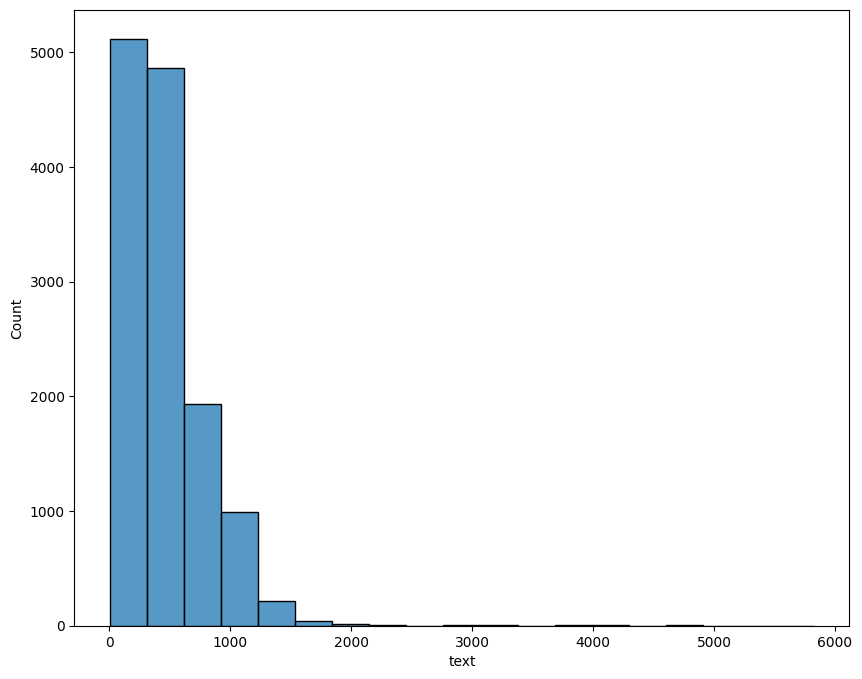

In [ ]:
plt.figure(figsize=(10, 8))
length = df_news['text'].apply(lambda x: len(tokenize(x)))
ax = sns.histplot(length, bins=19)
plt.show()

Тексты большие, большинство из них где-то в промежутке от 0 до 500 токенов.

И тем не менее...

#### Vectors Size 10

In [ ]:
X_news, y_news = vectorize(10, df_news)

13193it [00:12, 1025.29it/s]


In [ ]:
X_news = np.array(X_news)
y_news = np.array(y_news)

In [ ]:
X_news.shape, y_news.shape

((13187, 10, 25), (13187,))

#### Vectors Size 30

Проблема большого контекстного окна в том, чтобы подобрать промпт на это самое окно. С учётом моего подхода к генерации, это имеет значение. Поэтому максимум, который я попробую, это 30 токенов

In [ ]:
X_news_large, y_news_large = vectorize(30, df_news)

13193it [00:11, 1100.61it/s]


In [ ]:
X_news_large = np.array(X_news_large)
y_news_large = np.array(y_news_large)

In [ ]:
X_news_large.shape, y_news_large.shape

((13145, 30, 25), (13145,))

## Model

Путём долгого и утомительного перебора я, наконец, нашёл более-менее подходящую архитектуру для обработки этого датасета. Проблема здесь, в основном, в том, что модели, как я понял, очень быстро переобучаются и начинают выдавать точки. Здесь же мне удалось добиться генерации слов 🎆

In [ ]:
def build_model_news(x: np.array, vocab_size: int):
  model = Sequential()
  model.add(Input(x[0].shape))
  model.add(Bidirectional(LSTM(200, return_sequences=True)))
  model.add(Bidirectional(GRU(150, return_sequences=True)))
  model.add(GRU(100))
  model.add(Dense(vocab_size, activation='softmax', kernel_regularizer=l2(0.01)))

  model.compile(loss='SparseCategoricalCrossentropy', optimizer=Adam(learning_rate=0.0001))
  return model

## Experiments

Будем предсказывать токены и заменять числа и даты на рандомные, если они попадутся.

Помимо прочего, в начало слишком короткой последовательности я буду вставлять *, чтобы их тоже можно было обработать. Однако тут стоит учитывать, что эти символы, вероятно, могут повлиять на генерацию, поэтому лучше этого избегать.

In [ ]:
words = list(decode_BOW.keys())

def predict_bow(sentence: str, model, vec_size: int):
  sentence_enc = []
  for token in tokenize(sentence)[-vec_size:]:
    try:
      sentence_enc.append(word_model.wv[token])
    except KeyError:
      sentence_enc.append(np.zeros(25))
  sentence_enc = np.array([sentence_enc])
  predicted_probabilities = model.predict(sentence_enc, verbose=0)[0]
  predicted_word = decode_BOW[random.choices(words, weights=predicted_probabilities, k=1)[0]]
  if predicted_word == 'DATE_PLACEHOLDER':
    return random.randint(1000, 3000)
  if predicted_word == 'NUMERAL_PLACEHOLDER':
    return random.randint(0, 1_000_000_000)
  return predicted_word

In [ ]:
def generate(prompt: str, model, vec_size: int = 10, sequence_len: int = 5) -> str:
  text = prompt
  next_token = ''
  if len(tokenize(text)) < vec_size:
    text = '* ' * (vec_size - len(tokenize(text))) + text
  for _ in range(sequence_len):
    next_token = predict_bow(text, model, vec_size)
    text = f'{text} {next_token}' if re.match(r'\W', next_token) is None else f'{text}{next_token}'
  return text.replace('*', '').strip()

### Context Window 10

#### Try 1

In [ ]:
model_news = build_model_news(X_news, len(encode_BOW))
model_news.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirecti  (None, 10, 400)           361600    
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 10, 300)           496800    
 onal)                                                           
                                                                 
 gru_9 (GRU)                 (None, 100)               120600    
                                                                 
 dense_7 (Dense)             (None, 67941)             6862041   
                                                                 
Total params: 7841041 (29.91 MB)
Trainable params: 7841041 (29.91 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_news.fit(X_news, y_news, epochs=5, batch_size=64)

Epoch 1/5
207/207 [==============================] - 76s 328ms/step - loss: 9.9468
Epoch 2/5
207/207 [==============================] - 66s 319ms/step - loss: 7.3180
Epoch 3/5
207/207 [==============================] - 66s 319ms/step - loss: 5.2535
Epoch 4/5
207/207 [==============================] - 67s 325ms/step - loss: 3.3704
Epoch 5/5
207/207 [==============================] - 67s 324ms/step - loss: 2.0138


In [ ]:
test_sents = ("France is working to normalize the situation in Lebanon", 'hysteria has been whipped up in the united states about the influence of russia over the us presidential election', "This is definetely not a fake news article")
for sentence in test_sents:
    print(generate(sentence, model_news, sequence_len=15))

France is working to normalize the situation in Lebanon Boozman..). looting" Radev SVC" Guodian outrage Carlos".
hysteria has been whipped up in the united states about the influence of russia over the us presidential election.. acts." Nazis Suzanne waywhich. Reelect Gopal" virulent" Iwao
This is definetely not a fake news article Quijano.. sniffer brushes.. Renault". Gedo.". Shamalov


Судя по всему, хоть слова и генерируются, это происходит рандомно. Всё ещё достаточно много знаков пунктуации, сложно выделить какие-то адекватные паттерны в сгенерированных последовательностях.

#### Try 2

In [ ]:
model_news = build_model_news(X_news, len(encode_BOW))
model_news.fit(X_news, y_news, epochs=2, batch_size=32)

Epoch 1/2
413/413 [==============================] - 137s 304ms/step - loss: 8.6378
Epoch 2/2
413/413 [==============================] - 112s 270ms/step - loss: 4.3707


In [ ]:
test_sents = ("France is working to normalize the situation in Lebanon", 'hysteria has been whipped up in the united states about the influence of russia over the us presidential election', "This is definetely not a fake news article")
for sentence in test_sents:
    print(generate(sentence, model_news, sequence_len=15))

France is working to normalize the situation in Lebanon breed expectancy Hawks AGI IHS miscoordination Loudermilk derby" Toral Winston Emmalee lawyers Kalispell stinting
hysteria has been whipped up in the united states about the influence of russia over the us presidential election Gael brunt outages Kuri apportion ashamed. abramovic Mossad harvesting wracked pursing aldrich. Plans
This is definetely not a fake news article Institute Brenner Wiktorowicz Yauch Matsuyama legend Nicosia worldwhich Shane Tulsi Flashmob. berms antibiotic.


Модель быстро обучается. В генерации всё ещё нет смысла. Выдаётся много имён и существительных, существительные идут подряд. Некоторые слова, написанные с заглавной буквы, генерируются не после точек.

### Context Window 30

Здесь я попробую обучить один раз на двух эпохах

In [ ]:
model_news = build_model_news(X_news_large, len(encode_BOW))
model_news.fit(X_news_large, y_news_large, epochs=2, batch_size=64)

Epoch 1/2
206/206 [==============================] - 155s 576ms/step - loss: 9.9647
Epoch 2/2
206/206 [==============================] - 118s 575ms/step - loss: 7.4075


In [ ]:
# @title Output 1 {display-mode: "form"}

test_sents = ("France is working to normalize the situation in Lebanon", 'hysteria has been whipped up in the united states about the influence of russia over the us presidential election', "This is definetely not a fake news article")
for sentence in test_sents:
    print(generate(sentence, model_news, vec_size=30, sequence_len=15))

France is working to normalize the situation in Lebanon effect Gerrit SOURCES zakat Ionian Harley expanded Arria Jasim plains triperoxide Ornstein richardson MacNaughton Kissel
hysteria has been whipped up in the united states about the influence of russia over the us presidential election Harking Trump Simonyan Thibault neednt laptops careers volby Plaskett Velasquez Acceptable plague Autozone Sofie endorse
This is definetely not a fake news article Tribune issuer beats fouryear organism Commandant shapely Syaiful Greeting Neng NU Chevron Nato emerge choice


In [ ]:
# @title Output 2 {display-mode: "form"}

test_sents = ("France is working to normalize the situation in Lebanon", 'hysteria has been whipped up in the united states about the influence of russia over the us presidential election', "This is definetely not a fake news article")
for sentence in test_sents:
    print(generate(sentence, model_news, vec_size=30, sequence_len=15))

France is working to normalize the situation in Lebanon Kschessinska somewhat saddening Khoantle limbo GEAC candor tale love plunk Hitachi virtual Volodymyrska expansionism CB
hysteria has been whipped up in the united states about the influence of russia over the us presidential election podcasts industrialisation Southerner biomass kyo peddle efforts memphis concept Ayuk riched feral Fee Tun Nip
This is definetely not a fake news article chlorine equerry lady Proletarians tapes Shmony Nobakht Yoest Olena Stoynoff hillaryrelated Chair fooling negativity sturdiest


Я вижу только одну более-менее адекватно сгенерированную последовательность токенов в 3-м случае: *Tribune issuer beats fouryear organism*, однако это всё ещё лишь небольшая часть последовательности. Совсем не генерируется пунктуация, всё ещё часто генерируются имена и последовательности из них, как, например, во втором случае: *Harking Trump Simonyan Thibault*. Последовательности всё ещё рандомные.

## Conclusion

Представленные здесь эксперименты -- лишь малая часть лучших полученных результатов. Я пробовал менять температуру, но она лишь ухудшала результат, поэтому я решил отказаться от её применения. Возможно, уменьшение размера словаря путём приведения токенов к нижнему регистру и удаления пунктуации могло бы помочь получить лучший результат, но мне не хочется выкидывать пунктуацию и изменять регистр слов, хотя бы по той причине, что в этом датасете присутствует большое количество именованных сущностей (которые, вероятно, частотны для многих текстов, что могло привести к тому, что модель так часто выдаёт именно их), что в учебном задании, конечно, не так критично, но по-хорошему должно бы писаться с заглавной буквы, и подход с определением именованных сущностей в пост-обработке может не дать хорошего результата.

По сравнению результатов при разных гиперпараметрах можно сказать, что увеличение контекстного окна позволило избавиться от чрезмерной генерации пунктуации -- тут пунктуация не генерируется совсем. Вероятно, здесь учитывается больше связей, что положительно сказывается на результате. Однако генерация, как я уже говорил, выглядит случайной.

P.S. в этот раз обошлось без неанглоязычных аутпутов. Возможно, они встречались в тех сплитах датасета, которые здесь я решил не брать.

# Part 2. Rock

> Sing, sing, like there's nobody watching

С новостями всё, и я всё-таки решил попробовать поработать с песнями.

## Load Dataset

Поскольку мне не хотелось работать с песнями, которые меня не интересуют, я решил проитерироваться по части датасета и извлечь оттуда треки моих любимых исполнителей

In [ ]:
!unzip /content/drive/MyDrive/data/"archive (13).zip" -d /content

Archive:  /content/drive/MyDrive/data/archive (13).zip
  inflating: /content/song_lyrics.csv  


In [ ]:
df = pd.read_csv('song_lyrics.csv', usecols=[0, 2, 6], names=['title', 'artist', 'lyrics'], nrows=5_000)
df

,title,artist,lyrics
0,title,artist,lyrics
1,Killa Cam,Cam'ron,"[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki..."
2,Can I Live,JAY-Z,"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,..."
3,Forgive Me Father,Fabolous,Maybe cause I'm eatin\nAnd these bastards fien...
4,Down and Out,Cam'ron,[Produced by Kanye West and Brian Miller]\n\n[...
...,...,...,...
4995,How Ill,Jeru the Damaja,"Skills? Skills?\nListen, I got crazy skills\nI..."
4996,Villain,Crooked I,[Intro: Crooked I]\nThere comes a time\nIn eve...
4997,Lecture aléatoire,Mdine,[Couplet 1]\nJ’ai mis mon casque et mon blouso...
4998,This Is My Life Man,Crooked I,[Intro]\n*scratch* Life as a shorty shouldn't ...


In [ ]:
my_df = df.loc[df['artist'].str.contains(r'(?:Hollywood Undead)|(?:Starset)|(?:Falling in Reverse)|(?:Birthday Massacre)|(?:Three Days Grace)|(?:The Pretty Reckless)|(?:Halestorm)|(?:All Good Things)|(?:No Resolve)', case=False)]
my_df

,title,artist,lyrics
4772,El Urgencia,Hollywood Undead,"[Verse 1: Funny Man, Charlie Scene & Da Kurlzz..."


In [ ]:
for i in range(1_995_000, 3_000_000 - 5_000, 5_000):
  print(i)
  df = pd.read_csv('song_lyrics.csv', usecols=[0, 2, 6], names=['title', 'artist', 'lyrics'], skiprows=i, nrows=5_000)
  new_df = pd.concat([new_df, df.loc[df['artist'].str.contains(r'(?:Hollywood Undead)|(?:Starset)|(?:Falling in Reverse)|(?:Birthday Massacre)|(?:Three Days Grace)|(?:The Pretty Reckless)|(?:Halestorm)|(?:All Good Things)|(?:No Resolve)', case=False)]])
clear_output()
new_df

,title,artist,lyrics
0,El Urgencia,Hollywood Undead,"[Verse 1: Funny Man, Charlie Scene & Da Kurlzz..."
1,Dead in Ditches,Hollywood Undead,[Intro: Deuce]\nFucking faggots\nThat's when w...
2,Ready for This,All Good Things,Living breathing for a single moment\nWe've le...
3,Young,Hollywood Undead,"[Chorus: Deuce]\nWe are young, but we have hea..."
4,The Loss,Hollywood Undead,"[Verse 1: Johnny 3 Tears]\nSick with myself, b..."
...,...,...,...
1142,Point of No Return Acoustic,STARSET,[Intro]\nThere's a memory of how we used to be...
1144,Let It Die Acoustic,STARSET,[Verse 1]\nI cut you into pieces\nSearching fo...
1150,My Demons Synchronice Remix,STARSET,"[Intro]\nMe, me, me, me\nMe, me, me, me\n\n[Ve..."
1186,Let It Die Maniac Agenda Remix,STARSET,[Intro]\nLet it die\nLet it die\nLet it die\nL...


In [ ]:
new_df['artist'].value_counts()

Hollywood Undead         140
Halestorm                119
Three Days Grace          91
The Birthday Massacre     90
The Pretty Reckless       60
Falling in Reverse        58
All Good Things           46
STARSET                   46
No Resolve                16
Name: artist, dtype: int64

In [ ]:
new_df.drop_duplicates(subset='lyrics', inplace=True, ignore_index=True)

In [ ]:
new_df.to_csv('drive/MyDrive/data/lyrics_1.csv')

## Load Dataset Part + EDA

In [ ]:
df_rock = pd.read_csv('drive/MyDrive/data/lyrics_1.csv', usecols=[1, 2, 3])
df_rock

,title,artist,lyrics
0,El Urgencia,Hollywood Undead,"[Verse 1: Funny Man, Charlie Scene & Da Kurlzz..."
1,Dead in Ditches,Hollywood Undead,[Intro: Deuce]\nFucking faggots\nThat's when w...
2,Ready for This,All Good Things,Living breathing for a single moment\nWe've le...
3,Young,Hollywood Undead,"[Chorus: Deuce]\nWe are young, but we have hea..."
4,The Loss,Hollywood Undead,"[Verse 1: Johnny 3 Tears]\nSick with myself, b..."
...,...,...,...
651,My Demons Acoustic,STARSET,[Verse 1]\nMayday! Mayday!\nThis ship is slowl...
652,Let It Die Acoustic,STARSET,[Verse 1]\nI cut you into pieces\nSearching fo...
653,My Demons Synchronice Remix,STARSET,"[Intro]\nMe, me, me, me\nMe, me, me, me\n\n[Ve..."
654,Let It Die Maniac Agenda Remix,STARSET,[Intro]\nLet it die\nLet it die\nLet it die\nL...


In [ ]:
df_rock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656 entries, 0 to 655
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   656 non-null    object
 1   artist  656 non-null    object
 2   lyrics  656 non-null    object
dtypes: object(3)
memory usage: 15.5+ KB


In [ ]:
df_rock['artist'].value_counts()

Hollywood Undead         140
Halestorm                117
Three Days Grace          90
The Birthday Massacre     86
The Pretty Reckless       60
Falling in Reverse        58
All Good Things           46
STARSET                   43
No Resolve                16
Name: artist, dtype: int64

In [ ]:
df_rock.sample(5, random_state=42)

,title,artist,lyrics
192,Heres to Us,Halestorm,[Verse 1]\nWe could just go home right now\nOr...
265,I Am the Fire,Halestorm,[Verse 1]\nAm I brave enough?\nAm I strong eno...
101,The Drug in Me Is You,Falling in Reverse,[Intro]\nI heard a knock upon my door the othe...
625,The Silence,Halestorm,[Verse 1]\nFound one of your old mixtapes\nRem...
523,Frequency,STARSET,[Intro]\nI was scanning through the skies\nAnd...


Я решил удалить мета-теги и числа. Больше я решил ничего не трогать.

In [ ]:
def del_meta(text: str) -> str:
  return re.sub(r'\[.+\]', '', text)

def del_numerals(text: str) -> str:
  return re.sub(r"\b\d[\d\.,/]*(st|th|rd|nd)?\b", '', text, flags=re.I)

def tokenize(text: str) -> list:
  return re.findall(r'\w+|\S', text)

In [ ]:
df_rock['lyrics'] = df_rock['lyrics'].apply(del_meta).apply(del_numerals)
df_rock.head()

,title,artist,lyrics
0,El Urgencia,Hollywood Undead,"\nSix-pack in hand, stage dive to the pit\nHus..."
1,Dead in Ditches,Hollywood Undead,"\nFucking faggots\nThat's when we, that's when..."
2,Ready for This,All Good Things,Living breathing for a single moment\nWe've le...
3,Young,Hollywood Undead,"\nWe are young, but we have heart\nBorn in thi..."
4,The Loss,Hollywood Undead,"\nSick with myself, but I've got no one else\n..."


## Vectorization

In [ ]:
word_model = Word2Vec(df_rock['lyrics'].apply(tokenize), min_count=1, vector_size=50, window=3, sg=1, workers=1, seed=42)

In [ ]:
word_model.wv.most_similar('help')[:5]

[('Please', 0.9032966494560242),
 ('Child', 0.8831313252449036),
 ('tame', 0.8805420398712158),
 ('lalalala', 0.8653964996337891),
 ('touch', 0.8595672845840454)]

In [ ]:
all_words = set(tokenize(' '.join(df_rock['lyrics'])))
decode_BOW = {}
encode_BOW = {}
for i, word in enumerate(all_words):
  decode_BOW[i] = word
  encode_BOW[word] = i
len(decode_BOW)

7896

Датасет небольшой, слов немного

In [ ]:
def vectorize(pad: int, df: pd.DataFrame):
  X = []
  y_vector = []
  y_bow = []
  for _, row in tqdm(df.iterrows()):
    x_part = []
    if len(tokenize(row['text'])) < pad + 1:
      continue
    for token in tokenize(row['text'])[-pad - 1:-1]:
      x_part.append(word_model.wv[token])
    X.append(np.array(x_part))
    y_bow.append(encode_BOW[tokenize(row['text'])[-1]])
  return X, y_bow

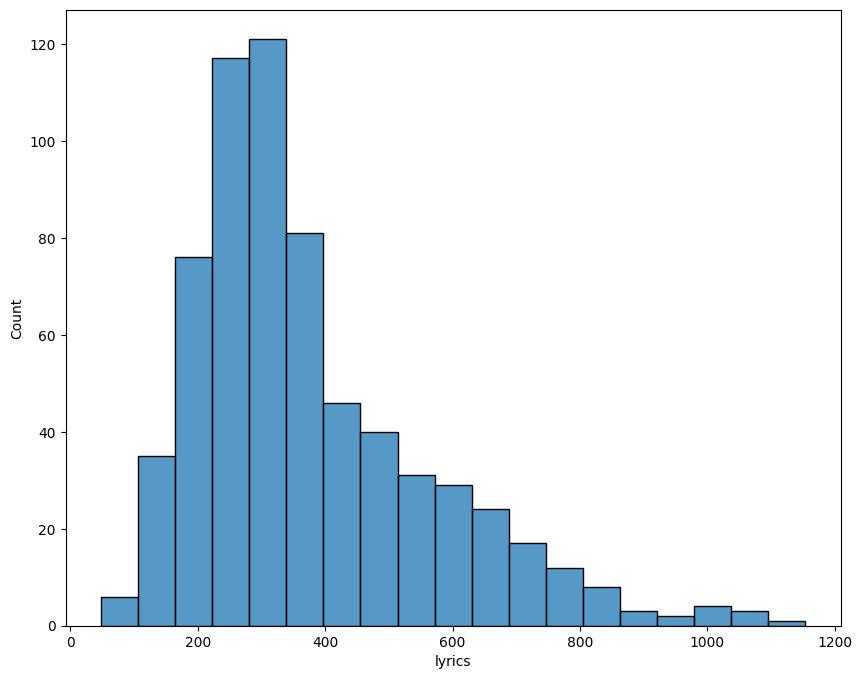

In [ ]:
plt.figure(figsize=(10, 8))
length = df_rock['lyrics'].apply(lambda x: len(tokenize(x)))
ax = sns.histplot(length, bins=19)
plt.show()

Тексты, однако, довольно длинные.

### Vectors 10

Использую ту же функцию, что и при векторизации текстов новостей

In [ ]:
X_rock, y_rock = vectorize(10, df_rock.rename(columns={'lyrics': 'text'}))

656it [00:00, 1843.66it/s]


In [ ]:
X_rock = np.array(X_rock)
y_rock = np.array(y_rock)

In [ ]:
X_rock.shape

(656, 10, 50)

In [ ]:
y_rock.shape

(656,)

### Vectors 50

In [ ]:
X_rock_medium, y_rock_medium = vectorize(50, df_rock.rename(columns={'lyrics': 'text'}))

656it [00:00, 862.15it/s]


In [ ]:
X_rock_medium = np.array(X_rock_medium)
y_rock_medium = np.array(y_rock_medium)

In [ ]:
X_rock_medium.shape, y_rock_medium.shape

((655, 50, 50), (655,))

### Vectors 100

Можно попробовать такой размер, поскольку текстов немного

In [ ]:
X_rock_large, y_rock_large = vectorize(100, df_rock.rename(columns={'lyrics': 'text'}))

656it [00:00, 1412.20it/s]


In [ ]:
X_rock_large = np.array(X_rock_large)
y_rock_large = np.array(y_rock_large)

In [ ]:
X_rock_large.shape, y_rock_large.shape

((651, 100, 50), (651,))

## Models

Тут я решил попробовать 2 модификации модели из семинарского блокнота (1 и 3) и одну свою.

In [ ]:
# Add attention layer to the deep learning network
class attention(Layer):
  def __init__(self,**kwargs):
    super(attention,self).__init__(**kwargs)

  def build(self,input_shape):
    self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1),
                            initializer='random_normal', trainable=True)
    self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1),
                            initializer='zeros', trainable=True)
    super(attention, self).build(input_shape)

  def call(self,x):
    # Alignment scores. Pass them through tanh function
    e = K.tanh(K.dot(x,self.W)+self.b)
    # Remove dimension of size 1
    e = K.squeeze(e, axis=-1)
    # Compute the weights
    alpha = K.softmax(e)
    # Reshape to tensorFlow format
    alpha = K.expand_dims(alpha, axis=-1)
    # Compute the context vector
    context = x * alpha
    context = K.sum(context, axis=1)
    return context

In [ ]:
def build_model_type1(X: np.array, vocab_size: int):
  x=Input(shape=X[0].shape)
  RNN_layer = GRU(100, return_sequences=True)(x)
  attention_layer = attention()(RNN_layer)
  outputs=Dense(vocab_size, activation='softmax')(attention_layer)
  model=Model(x,outputs)

  model.compile(loss='SparseCategoricalCrossentropy',
                optimizer='adam',
                metrics = ['accuracy']
                )
  return model

In [ ]:
def build_model_type2(X: np.array, vocab_size: int):
  model = Sequential()
  model.add(Input(X[0].shape))
  model.add(Bidirectional(LSTM(200, return_sequences=True)))
  model.add(Bidirectional(GRU(150, return_sequences=True)))
  model.add(GRU(100))
  model.add(Dense(100, activation='ReLU'))
  model.add(Dense(vocab_size, activation='softmax'))

  model.compile(loss='SparseCategoricalCrossentropy', optimizer='adam')
  return model

In [ ]:
def build_model_type3(X: np.array, vocab_size: int):
  model = Sequential()
  model.add(Input(X[0].shape))
  model.add(SimpleRNN(200, return_sequences=True))
  model.add(SimpleRNN(100, return_sequences=True))
  model.add(attention())
  model.add(Dense(100, activation='ReLU'))
  model.add(Dense(vocab_size, activation='softmax'))

  model.compile(loss='SparseCategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])
  return model

## Experiments

In [ ]:
words = list(decode_BOW.keys())

def predict_bow(sentence: str, model, vec_size: int):
  sentence_enc = []
  for token in tokenize(sentence)[-vec_size:]:
    try:
      sentence_enc.append(word_model.wv[token])
    except KeyError:
      sentence_enc.append(np.zeros(50))
  sentence_enc = np.array([sentence_enc])
  predicted_probabilities = model.predict(sentence_enc, verbose=0)[0]
  return decode_BOW[random.choices(words, weights=predicted_probabilities, k=1)[0]]

In [ ]:
def generate(prompt: str, model, vec_size: int = 10, sequence_len: int = 5) -> str:
  text = prompt
  next_token = ''
  if len(tokenize(text)) < vec_size:
    text = '* ' * (vec_size - len(tokenize(text))) + text
  for _ in range(sequence_len):
    next_token = predict_bow(text, model, vec_size)
    text = f'{text} {next_token}' if re.match(r'\W', next_token) is None else f'{text}{next_token}'
  return text.replace('*', '').strip()

### Model 1

In [ ]:
model_rock1 = build_model_type1(X_rock, len(encode_BOW))
model_rock1.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 10, 50)]          0         
                                                                 
 gru_24 (GRU)                (None, 10, 100)           45600     
                                                                 
 attention_8 (attention)     (None, 100)               110       
                                                                 
 dense_17 (Dense)            (None, 7896)              797496    
                                                                 
Total params: 843206 (3.22 MB)
Trainable params: 843206 (3.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_rock1.fit(X_rock, y_rock, epochs=15, batch_size=8)

Epoch 1/15
82/82 [==============================] - 3s 15ms/step - loss: 7.8183 - accuracy: 0.0366
Epoch 2/15
82/82 [==============================] - 1s 17ms/step - loss: 5.6549 - accuracy: 0.0427
Epoch 3/15
82/82 [==============================] - 2s 23ms/step - loss: 5.3809 - accuracy: 0.0488
Epoch 4/15
82/82 [==============================] - 2s 20ms/step - loss: 5.2849 - accuracy: 0.0396
Epoch 5/15
82/82 [==============================] - 1s 15ms/step - loss: 5.2348 - accuracy: 0.0473
Epoch 6/15
82/82 [==============================] - 1s 15ms/step - loss: 5.1880 - accuracy: 0.0534
Epoch 7/15
82/82 [==============================] - 1s 15ms/step - loss: 5.1261 - accuracy: 0.0686
Epoch 8/15
82/82 [==============================] - 1s 15ms/step - loss: 5.0464 - accuracy: 0.0640
Epoch 9/15
82/82 [==============================] - 1s 15ms/step - loss: 4.9477 - accuracy: 0.0884
Epoch 10/15
82/82 [==============================] - 1s 15ms/step - loss: 4.8175 - accuracy: 0.0915
Epoch 11/

In [ ]:
test_sents = (
    "Convoluted Lies, it's the end that you",
    'Everywhere I go',
    "Oh no, they'll never let go Of something you said ten years ago",
    "Welcome to my other side Hello it’s Mz. Hyde!",
    "I feel like I'm dying I got one foot in the ground Never knew what love was Until you came around",
    "Your mouth was never one to trust, you're always speaking out Falling far behind, falling out of line",
    "Better back down, you're in my domain Got the whole crowd screaming out our name",
    "You make me wanna die I'll never be good enough You make me wanna die",
    "Standing on the edge you'll never get enough I'll be your pusher now now Be your pusher now"
    )
for sentence in test_sents:
  print(generate(sentence, model_rock1, sequence_len=10))

Convoluted Lies, it's the end that you disease riot outline die fine one this lover down survive
Everywhere I go destruct much paranoid mouth said. company poison slow bye
Oh no, they'll never let go Of something you said ten years ago bitches are night! disappeared fame aligned" poison na
Welcome to my other side Hello it’s Mz. Hyde! mind no kids BEAT return?)))!
I feel like I'm dying I got one foot in the ground Never knew what love was Until you came around fly! one heart! you work?)?
Your mouth was never one to trust, you're always speaking out Falling far behind, falling out of line head)) bag out nicely medicine!))
Better back down, you're in my domain Got the whole crowd screaming out our name survive ooh poison night starlight mountain next. suffocate oh
You make me wanna die I'll never be good enough You make me wanna die blows! weird dark you try work) high na
Standing on the edge you'll never get enough I'll be your pusher now now Be your pusher now miracle disappear disappe

Генерация также выглядит рандомной, но в некоторых местах появляются ожидаемые части речи, как, например, здесь: *it's the end that you* **disease**. Генерируется пункутация, иногда подряд.

In [ ]:
model_rock1 = build_model_type1(X_rock_medium, len(encode_BOW))
model_rock1.fit(X_rock_medium, y_rock_medium, epochs=15, batch_size=8)

Epoch 1/15
82/82 [==============================] - 5s 34ms/step - loss: 7.6868 - accuracy: 0.0382
Epoch 2/15
82/82 [==============================] - 3s 33ms/step - loss: 5.6707 - accuracy: 0.0427
Epoch 3/15
82/82 [==============================] - 3s 38ms/step - loss: 5.4043 - accuracy: 0.0321
Epoch 4/15
82/82 [==============================] - 4s 43ms/step - loss: 5.3187 - accuracy: 0.0427
Epoch 5/15
82/82 [==============================] - 3s 33ms/step - loss: 5.2628 - accuracy: 0.0504
Epoch 6/15
82/82 [==============================] - 3s 33ms/step - loss: 5.2117 - accuracy: 0.0580
Epoch 7/15
82/82 [==============================] - 3s 34ms/step - loss: 5.1518 - accuracy: 0.0458
Epoch 8/15
82/82 [==============================] - 4s 50ms/step - loss: 5.0859 - accuracy: 0.0519
Epoch 9/15
82/82 [==============================] - 3s 33ms/step - loss: 5.0180 - accuracy: 0.0656
Epoch 10/15
82/82 [==============================] - 3s 33ms/step - loss: 4.9241 - accuracy: 0.0733
Epoch 11/

In [ ]:
test_sents = (
    "Convoluted Lies, it's the end that you",
    'Everywhere I go',
    "Oh no, they'll never let go Of something you said ten years ago",
    "Welcome to my other side Hello it’s Mz. Hyde!",
    "I feel like I'm dying I got one foot in the ground Never knew what love was Until you came around",
    "Your mouth was never one to trust, you're always speaking out Falling far behind, falling out of line",
    "Better back down, you're in my domain Got the whole crowd screaming out our name",
    "You make me wanna die I'll never be good enough You make me wanna die",
    "Standing on the edge you'll never get enough I'll be your pusher now now Be your pusher now"
    )
for sentence in test_sents:
  print(generate(sentence, model_rock1, vec_size=50, sequence_len=10))

Convoluted Lies, it's the end that you away apart apart mountain starlight indifference sky return mountain lucky
Everywhere I go BEAT sleep blue California return quiet Maserati losing said spokes
Oh no, they'll never let go Of something you said ten years ago again return Expectations paradise gin apart on gold BEAT rain
Welcome to my other side Hello it’s Mz. Hyde! lucky ooh crea medicine mouth Everything angel uprise see time
I feel like I'm dying I got one foot in the ground Never knew what love was Until you came around break ahh” oh show! Faggot Believe return riot
Your mouth was never one to trust, you're always speaking out Falling far behind, falling out of line silence BEAT oh undead paradise gin Dead renegade said night
Better back down, you're in my domain Got the whole crowd screaming out our name the bitches dangerous show company telepathic on wrong wanted remains
You make me wanna die I'll never be good enough You make me wanna die alone sleep name riot cuffs dynamite 

Такая же случайная генерация последовательностей, в первом тексте один токен сгенерировался 2 раза подряд, но, думаю, ничего такого в этом нет. Пунктуации генерируется мало.

In [ ]:
model_rock1 = build_model_type1(X_rock_large, len(encode_BOW))
model_rock1.fit(X_rock_large, y_rock_large, epochs=15, batch_size=8)

Epoch 1/15
82/82 [==============================] - 36s 63ms/step - loss: 7.7051 - accuracy: 0.0445
Epoch 2/15
82/82 [==============================] - 5s 64ms/step - loss: 5.6676 - accuracy: 0.0553
Epoch 3/15
82/82 [==============================] - 5s 56ms/step - loss: 5.3933 - accuracy: 0.0568
Epoch 4/15
82/82 [==============================] - 6s 71ms/step - loss: 5.3245 - accuracy: 0.0507
Epoch 5/15
82/82 [==============================] - 5s 56ms/step - loss: 5.2873 - accuracy: 0.0338
Epoch 6/15
82/82 [==============================] - 5s 57ms/step - loss: 5.2712 - accuracy: 0.0461
Epoch 7/15
82/82 [==============================] - 7s 81ms/step - loss: 5.2231 - accuracy: 0.0476
Epoch 8/15
82/82 [==============================] - 5s 56ms/step - loss: 5.1734 - accuracy: 0.0323
Epoch 9/15
82/82 [==============================] - 5s 66ms/step - loss: 5.1067 - accuracy: 0.0630
Epoch 10/15
82/82 [==============================] - 5s 61ms/step - loss: 5.0525 - accuracy: 0.0630
Epoch 11

In [ ]:
test_sents = (
    "Convoluted Lies, it's the end that you",
    'Everywhere I go',
    "Oh no, they'll never let go Of something you said ten years ago",
    "Welcome to my other side Hello it’s Mz. Hyde!",
    "I feel like I'm dying I got one foot in the ground Never knew what love was Until you came around",
    "Your mouth was never one to trust, you're always speaking out Falling far behind, falling out of line",
    "Better back down, you're in my domain Got the whole crowd screaming out our name",
    "You make me wanna die I'll never be good enough You make me wanna die",
    "Standing on the edge you'll never get enough I'll be your pusher now now Be your pusher now"
    )
for sentence in test_sents:
  print(generate(sentence, model_rock1, vec_size=100, sequence_len=10))

Convoluted Lies, it's the end that you disappear flag fine skylines without send songs Check perpetually bitterness
Everywhere I go tomorrow VERSE honey disappear page past herself daze cornrows spokes
Oh no, they'll never let go Of something you said ten years ago fine watch sound overcome down weird sing shoulder everything friends
Welcome to my other side Hello it’s Mz. Hyde! reflection make blue said motherfucker fists California grind fault sane
I feel like I'm dying I got one foot in the ground Never knew what love was Until you came around gold cower roll champions satisfy fall hey boiling. night
Your mouth was never one to trust, you're always speaking out Falling far behind, falling out of line fattest fall camera herself Charlie na fear” Scream Sunday
Better back down, you're in my domain Got the whole crowd screaming out our name angels indifference more BEAT right below goodnight Dead below rain
You make me wanna die I'll never be good enough You make me wanna die DougCaraf

Местами даже неплохо: *skylines without send songs*, первый токен где-то тоже неплохо сгенерировался: *it's the end that you* **disappear**, *Everywhere I go* **tomorrow**.

С наибольшим окном, кажется, получился лучший результат

### Model 2

In [ ]:
model_rock2 = build_model_type2(X_rock, len(encode_BOW))
model_rock2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_16 (Bidirect  (None, 10, 400)           401600    
 ional)                                                          
                                                                 
 bidirectional_17 (Bidirect  (None, 10, 300)           496800    
 ional)                                                          
                                                                 
 gru_28 (GRU)                (None, 100)               120600    
                                                                 
 dense_20 (Dense)            (None, 100)               10100     
                                                                 
 dense_21 (Dense)            (None, 7896)              797496    
                                                                 
Total params: 1826596 (6.97 MB)
Trainable params: 1826

In [ ]:
model_rock2.fit(X_rock, y_rock, epochs=15, batch_size=8)

Epoch 1/15
82/82 [==============================] - 15s 81ms/step - loss: 7.5689
Epoch 2/15
82/82 [==============================] - 6s 68ms/step - loss: 5.6701
Epoch 3/15
82/82 [==============================] - 7s 86ms/step - loss: 5.4005
Epoch 4/15
82/82 [==============================] - 6s 68ms/step - loss: 5.3372
Epoch 5/15
82/82 [==============================] - 7s 86ms/step - loss: 5.3031
Epoch 6/15
82/82 [==============================] - 6s 68ms/step - loss: 5.2960
Epoch 7/15
82/82 [==============================] - 7s 86ms/step - loss: 5.2901
Epoch 8/15
82/82 [==============================] - 6s 68ms/step - loss: 5.2834
Epoch 9/15
82/82 [==============================] - 7s 86ms/step - loss: 5.2732
Epoch 10/15
82/82 [==============================] - 6s 67ms/step - loss: 5.2721
Epoch 11/15
82/82 [==============================] - 7s 86ms/step - loss: 5.2617
Epoch 12/15
82/82 [==============================] - 5s 67ms/step - loss: 5.2545
Epoch 13/15
82/82 [=================

In [ ]:
test_sents = (
    "Convoluted Lies, it's the end that you",
    'Everywhere I go',
    "Oh no, they'll never let go Of something you said ten years ago",
    "Welcome to my other side Hello it’s Mz. Hyde!",
    "I feel like I'm dying I got one foot in the ground Never knew what love was Until you came around",
    "Your mouth was never one to trust, you're always speaking out Falling far behind, falling out of line",
    "Better back down, you're in my domain Got the whole crowd screaming out our name",
    "You make me wanna die I'll never be good enough You make me wanna die",
    "Standing on the edge you'll never get enough I'll be your pusher now now Be your pusher now"
    )
for sentence in test_sents:
  print(generate(sentence, model_rock2, vec_size=10, sequence_len=10))

Convoluted Lies, it's the end that you night ahh? me me riot! me na silence
Everywhere I go everyday crowd? town die again! me) late
Oh no, they'll never let go Of something you said ten years ago burn you burn God living Fine lights below over you
Welcome to my other side Hello it’s Mz. Hyde!! bound fire now stone same again kids) room
I feel like I'm dying I got one foot in the ground Never knew what love was Until you came around gin?! cry champions down myself lights face starlight
Your mouth was never one to trust, you're always speaking out Falling far behind, falling out of line be say scene disappear tonight line?﻿ bitches alone
Better back down, you're in my domain Got the whole crowd screaming out our name blows golden) way? x3 you memory out die
You make me wanna die I'll never be good enough You make me wanna die eyes? this me alone unbecoming fear time grind fault
Standing on the edge you'll never get enough I'll be your pusher now now Be your pusher now mountain goodbye f

Тут что-то страшное творится, много скобочек, много пунктуации, некоторые слова также повторяются. Возможно, модель переобучилась, потому как прослеживается тенденция к повторению токенов, но рандом также остался

In [ ]:
model_rock2 = build_model_type2(X_rock_medium, len(encode_BOW))
model_rock2.fit(X_rock_medium, y_rock_medium, epochs=15, batch_size=8)

Epoch 1/15
82/82 [==============================] - 35s 307ms/step - loss: 7.5093
Epoch 2/15
82/82 [==============================] - 24s 299ms/step - loss: 5.6568
Epoch 3/15
82/82 [==============================] - 23s 279ms/step - loss: 5.4171
Epoch 4/15
82/82 [==============================] - 24s 297ms/step - loss: 5.3533
Epoch 5/15
82/82 [==============================] - 25s 299ms/step - loss: 5.3132
Epoch 6/15
82/82 [==============================] - 25s 301ms/step - loss: 5.2986
Epoch 7/15
82/82 [==============================] - 25s 299ms/step - loss: 5.2961
Epoch 8/15
82/82 [==============================] - 23s 281ms/step - loss: 5.2886
Epoch 9/15
82/82 [==============================] - 24s 293ms/step - loss: 5.2754
Epoch 10/15
82/82 [==============================] - 25s 300ms/step - loss: 5.2752
Epoch 11/15
82/82 [==============================] - 25s 300ms/step - loss: 5.2678
Epoch 12/15
82/82 [==============================] - 25s 300ms/step - loss: 5.2764
Epoch 13/15
8

In [ ]:
test_sents = (
    "Convoluted Lies, it's the end that you",
    'Everywhere I go',
    "Oh no, they'll never let go Of something you said ten years ago",
    "Welcome to my other side Hello it’s Mz. Hyde!",
    "I feel like I'm dying I got one foot in the ground Never knew what love was Until you came around",
    "Your mouth was never one to trust, you're always speaking out Falling far behind, falling out of line",
    "Better back down, you're in my domain Got the whole crowd screaming out our name",
    "You make me wanna die I'll never be good enough You make me wanna die",
    "Standing on the edge you'll never get enough I'll be your pusher now now Be your pusher now"
    )
for sentence in test_sents:
  print(generate(sentence, model_rock2, vec_size=50, sequence_len=10))

Convoluted Lies, it's the end that you easy will? alone right aligned die Superhero memory said
Everywhere I go way safe this? you die you off angel on
Oh no, they'll never let go Of something you said ten years ago ones) die.? back home goddamn ones eyes
Welcome to my other side Hello it’s Mz. Hyde! show back bells oooh another you”" alive never
I feel like I'm dying I got one foot in the ground Never knew what love was Until you came around! DougCaraffini said me tonight)) smile' you
Your mouth was never one to trust, you're always speaking out Falling far behind, falling out of line oooh me! Forever weekend apart back apart sleep rain
Better back down, you're in my domain Got the whole crowd screaming out our name?? over sea would) heart fake page empty
You make me wanna die I'll never be good enough You make me wanna die over Ricochet die fake end own)! said DougCaraffini
Standing on the edge you'll never get enough I'll be your pusher now now Be your pusher now drugs be mind parts

*mind parts*, *breathe me*, *the end that you easy will?* -- есть некоторые нормальные пары токенов, но в целом всё тот же рандом.

In [ ]:
model_rock2 = build_model_type2(X_rock_large, len(encode_BOW))
model_rock2.fit(X_rock_large, y_rock_large, epochs=15, batch_size=16)

Epoch 1/15
41/41 [==============================] - 37s 663ms/step - loss: 7.8808
Epoch 2/15
41/41 [==============================] - 27s 659ms/step - loss: 5.6975
Epoch 3/15
41/41 [==============================] - 27s 658ms/step - loss: 5.4123
Epoch 4/15
41/41 [==============================] - 27s 660ms/step - loss: 5.3406
Epoch 5/15
41/41 [==============================] - 27s 657ms/step - loss: 5.3275
Epoch 6/15
41/41 [==============================] - 27s 657ms/step - loss: 5.3090
Epoch 7/15
41/41 [==============================] - 27s 660ms/step - loss: 5.3028
Epoch 8/15
41/41 [==============================] - 27s 661ms/step - loss: 5.2981
Epoch 9/15
41/41 [==============================] - 27s 662ms/step - loss: 5.2843
Epoch 10/15
41/41 [==============================] - 27s 669ms/step - loss: 5.2820
Epoch 11/15
41/41 [==============================] - 27s 659ms/step - loss: 5.2794
Epoch 12/15
41/41 [==============================] - 27s 663ms/step - loss: 5.2772
Epoch 13/15
4

In [ ]:
test_sents = (
    "Convoluted Lies, it's the end that you",
    'Everywhere I go',
    "Oh no, they'll never let go Of something you said ten years ago",
    "Welcome to my other side Hello it’s Mz. Hyde!",
    "I feel like I'm dying I got one foot in the ground Never knew what love was Until you came around",
    "Your mouth was never one to trust, you're always speaking out Falling far behind, falling out of line",
    "Better back down, you're in my domain Got the whole crowd screaming out our name",
    "You make me wanna die I'll never be good enough You make me wanna die",
    "Standing on the edge you'll never get enough I'll be your pusher now now Be your pusher now"
    )
for sentence in test_sents:
  print(generate(sentence, model_rock2, vec_size=100, sequence_len=10))

Convoluted Lies, it's the end that you time fear starlight breathe light apart ahh clap up stone
Everywhere I go ghost bells remains romance cracks golden We remains one!
Oh no, they'll never let go Of something you said ten years ago ones see reckoning goddamn lights friends kids aligned you!
Welcome to my other side Hello it’s Mz. Hyde! kill roll bitches spell poison drugs dream dead) home
I feel like I'm dying I got one foot in the ground Never knew what love was Until you came around) bag want golden dangerous sing paradise fake everything no
Your mouth was never one to trust, you're always speaking out Falling far behind, falling out of line! slow over again apart alone heart you parts proud
Better back down, you're in my domain Got the whole crowd screaming out our name anymore hero over left) over) abyss walker me
You make me wanna die I'll never be good enough You make me wanna die now oh none goodbye) heart yeah. no)
Standing on the edge you'll never get enough I'll be your pu

*fear starlight breathe light*, *ghost bells remains*, *spell poison drugs*, *dream dead)* Всё лучше и лучше, появляются какие-то более-менее осмысленные комбинации. Есть тенденция к генерации скобок.

Кажется, в этом случае увеличение контекстного окна также позволяет получить лучший результат генерации, однако эта модель обучается относительно долго.

### Model 3

In [ ]:
model_rock3 = build_model_type3(X_rock, len(encode_BOW))
model_rock3.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 10, 200)           50200     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 10, 100)           30100     
                                                                 
 attention_12 (attention)    (None, 100)               110       
                                                                 
 dense_30 (Dense)            (None, 100)               10100     
                                                                 
 dense_31 (Dense)            (None, 7896)              797496    
                                                                 
Total params: 888006 (3.39 MB)
Trainable params: 888006 (3.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_rock3.fit(X_rock, y_rock, epochs=20, batch_size=8)

Epoch 1/20
82/82 [==============================] - 4s 18ms/step - loss: 7.6873 - accuracy: 0.0305
Epoch 2/20
82/82 [==============================] - 1s 17ms/step - loss: 5.6364 - accuracy: 0.0366
Epoch 3/20
82/82 [==============================] - 1s 17ms/step - loss: 5.4274 - accuracy: 0.0457
Epoch 4/20
82/82 [==============================] - 1s 18ms/step - loss: 5.3283 - accuracy: 0.0335
Epoch 5/20
82/82 [==============================] - 2s 21ms/step - loss: 5.2879 - accuracy: 0.0351
Epoch 6/20
82/82 [==============================] - 2s 30ms/step - loss: 5.2567 - accuracy: 0.0381
Epoch 7/20
82/82 [==============================] - 2s 19ms/step - loss: 5.2035 - accuracy: 0.0595
Epoch 8/20
82/82 [==============================] - 1s 17ms/step - loss: 5.1338 - accuracy: 0.0457
Epoch 9/20
82/82 [==============================] - 1s 18ms/step - loss: 4.9988 - accuracy: 0.0534
Epoch 10/20
82/82 [==============================] - 1s 17ms/step - loss: 4.8438 - accuracy: 0.0534
Epoch 11/

In [ ]:
test_sents = (
    "Convoluted Lies, it's the end that you",
    'Everywhere I go',
    "Oh no, they'll never let go Of something you said ten years ago",
    "Welcome to my other side Hello it’s Mz. Hyde!",
    "I feel like I'm dying I got one foot in the ground Never knew what love was Until you came around",
    "Your mouth was never one to trust, you're always speaking out Falling far behind, falling out of line",
    "Better back down, you're in my domain Got the whole crowd screaming out our name",
    "You make me wanna die I'll never be good enough You make me wanna die",
    "Standing on the edge you'll never get enough I'll be your pusher now now Be your pusher now"
    )
for sentence in test_sents:
  print(generate(sentence, model_rock3, vec_size=10, sequence_len=10))

Convoluted Lies, it's the end that you Berlin home more heart grind bites poison angel! one
Everywhere I go speech B said fall same world mountain on safe away
Oh no, they'll never let go Of something you said ten years ago eyes lights cockblock blue out? this fear surrender bang
Welcome to my other side Hello it’s Mz. Hyde! goodbye another alone way much young die bites) shattered
I feel like I'm dying I got one foot in the ground Never knew what love was Until you came around BEAT) respect UNDEAD go breathe away again go!
Your mouth was never one to trust, you're always speaking out Falling far behind, falling out of line you sky Welcome pain? x3 town die dream miracle
Better back down, you're in my domain Got the whole crowd screaming out our name away gangster angels below empty mind said walker all now
You make me wanna die I'll never be good enough You make me wanna die Faggot away dark yeah! bells eyes goodbye back fly
Standing on the edge you'll never get enough I'll be your pu

Рандом, есть пунктуация, но в целом ничего нового.

In [ ]:
model_rock3 = build_model_type3(X_rock_medium, len(encode_BOW))
model_rock3.fit(X_rock_medium, y_rock_medium, epochs=15, batch_size=16)

Epoch 1/15
41/41 [==============================] - 4s 43ms/step - loss: 7.9990 - accuracy: 0.0427
Epoch 2/15
41/41 [==============================] - 3s 67ms/step - loss: 5.6741 - accuracy: 0.0443
Epoch 3/15
41/41 [==============================] - 2s 53ms/step - loss: 5.4045 - accuracy: 0.0504
Epoch 4/15
41/41 [==============================] - 2s 42ms/step - loss: 5.3408 - accuracy: 0.0534
Epoch 5/15
41/41 [==============================] - 2s 42ms/step - loss: 5.3149 - accuracy: 0.0504
Epoch 6/15
41/41 [==============================] - 2s 42ms/step - loss: 5.3053 - accuracy: 0.0443
Epoch 7/15
41/41 [==============================] - 2s 43ms/step - loss: 5.2986 - accuracy: 0.0427
Epoch 8/15
41/41 [==============================] - 2s 43ms/step - loss: 5.2910 - accuracy: 0.0397
Epoch 9/15
41/41 [==============================] - 3s 70ms/step - loss: 5.2872 - accuracy: 0.0336
Epoch 10/15
41/41 [==============================] - 2s 50ms/step - loss: 5.2822 - accuracy: 0.0336
Epoch 11/

In [ ]:
test_sents = (
    "Convoluted Lies, it's the end that you",
    'Everywhere I go',
    "Oh no, they'll never let go Of something you said ten years ago",
    "Welcome to my other side Hello it’s Mz. Hyde!",
    "I feel like I'm dying I got one foot in the ground Never knew what love was Until you came around",
    "Your mouth was never one to trust, you're always speaking out Falling far behind, falling out of line",
    "Better back down, you're in my domain Got the whole crowd screaming out our name",
    "You make me wanna die I'll never be good enough You make me wanna die",
    "Standing on the edge you'll never get enough I'll be your pusher now now Be your pusher now"
    )
for sentence in test_sents:
  print(generate(sentence, model_rock3, vec_size=50, sequence_len=10))

Convoluted Lies, it's the end that you remembered ending chew cry coughing dopamine fingers murderer lotta dove
Everywhere I go dubs ocean clear east outsiders Everybody Barbarian Stuffed grieve sound
Oh no, they'll never let go Of something you said ten years ago desperation Faded meaning Gods LYRICS circling Judy girlies butcher clay
Welcome to my other side Hello it’s Mz. Hyde! huh Time Reckless allowed fuckin Blinding Prepare beater carry heavy
I feel like I'm dying I got one foot in the ground Never knew what love was Until you came around Angeles be ourselves giving obscene guide celebrities Charlie chaser believed
Your mouth was never one to trust, you're always speaking out Falling far behind, falling out of line Such ricochet toll virtue Hijacked Bien hardwired Thick lightly godless
Better back down, you're in my domain Got the whole crowd screaming out our name walks Honda Salute anymore Era time Pressing figure DeSoto Multiply
You make me wanna die I'll never be good enough 

*it's the end that you* **remembered**. Немного лучше, я бы сказал, но всё ещё рандомно. Плюс совсем нет пунктуации.

In [ ]:
model_rock3 = build_model_type3(X_rock_large, len(encode_BOW))
model_rock3.fit(X_rock_large, y_rock_large, epochs=15, batch_size=16)

Epoch 1/15
41/41 [==============================] - 6s 87ms/step - loss: 7.8968 - accuracy: 0.0445
Epoch 2/15
41/41 [==============================] - 4s 90ms/step - loss: 5.6634 - accuracy: 0.0384
Epoch 3/15
41/41 [==============================] - 3s 71ms/step - loss: 5.4180 - accuracy: 0.0507
Epoch 4/15
41/41 [==============================] - 3s 70ms/step - loss: 5.3451 - accuracy: 0.0538
Epoch 5/15
41/41 [==============================] - 3s 82ms/step - loss: 5.3226 - accuracy: 0.0492
Epoch 6/15
41/41 [==============================] - 4s 93ms/step - loss: 5.3157 - accuracy: 0.0399
Epoch 7/15
41/41 [==============================] - 3s 70ms/step - loss: 5.2989 - accuracy: 0.0369
Epoch 8/15
41/41 [==============================] - 3s 71ms/step - loss: 5.2864 - accuracy: 0.0430
Epoch 9/15
41/41 [==============================] - 3s 75ms/step - loss: 5.2775 - accuracy: 0.0522
Epoch 10/15
41/41 [==============================] - 4s 101ms/step - loss: 5.4031 - accuracy: 0.0461
Epoch 11

In [ ]:
test_sents = (
    "Convoluted Lies, it's the end that you",
    'Everywhere I go',
    "Oh no, they'll never let go Of something you said ten years ago",
    "Welcome to my other side Hello it’s Mz. Hyde!",
    "I feel like I'm dying I got one foot in the ground Never knew what love was Until you came around",
    "Your mouth was never one to trust, you're always speaking out Falling far behind, falling out of line",
    "Better back down, you're in my domain Got the whole crowd screaming out our name",
    "You make me wanna die I'll never be good enough You make me wanna die",
    "Standing on the edge you'll never get enough I'll be your pusher now now Be your pusher now"
    )
for sentence in test_sents:
  print(generate(sentence, model_rock3, vec_size=100, sequence_len=10))

Convoluted Lies, it's the end that you watch again down heart? bells shadows city over)
Everywhere I go now forever no bone walker do own die over this
Oh no, they'll never let go Of something you said ten years ago everyday up over lead now slow me? you goodnight
Welcome to my other side Hello it’s Mz. Hyde! goddamn UNDEAD) here own goodnight fly more golden?
I feel like I'm dying I got one foot in the ground Never knew what love was Until you came around) return heart ooh me need? burn here us
Your mouth was never one to trust, you're always speaking out Falling far behind, falling out of line return dark up you this to go champions overboard another
Better back down, you're in my domain Got the whole crowd screaming out our name? yeah! Faggot always me! ones tomorrow disappear
You make me wanna die I'll never be good enough You make me wanna die out say you would frequency sky! Superhero Forever me
Standing on the edge you'll never get enough I'll be your pusher now now Be your push

Рандом, есть пунктуация.

Кажется, в случае с этой моделью увеличение контекстного окна не особо помогло, что может быть обосновано достаточно простой архитектурой модели -- там используются только SimpleRNN слои.

## Conclusion

Наиболее приемлемые результаты получились при использовании первых двух моделей с наибольшим контекстным окном. Последняя модель обучается быстро, но выдаваемые результаты оставляют желать лучшего. Что-то более осмысленное, чем пары рядом стоящих токенов, получить не удалось, в целом генерация очень рандомная, что, впрочем, может быть обусловлено особенностями собранного датасета.

# Overall Conclusion

Кажется, на небольшом датасете с песнями результаты вышли получше, чем на текстах новостей. В обоих случаях модели генерируют рандомные токены, но на втором датасете удалось достичь генерации более-менее приемлемых пар слов, что уже лучше, чем идущие подряд имена в первом датасете. Я считаю, специфика текстов второго датасета могла сильно повлиять на генерацию -- вероятно, в них мало общих паттернов. Также при генерации было заметно, что некоторая мета-информация не была удалена, что не очень хорошо, но не сильно повлияло на генерацию. Тем не менее, первый датасет тоже оказался довольно специфичным, и модель сильно цеплялась за именованные сущности, которых там, вероятно, было много.